In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from os import path
import os
from astropy.io import fits
from sklearn.metrics import mean_squared_error

from spectrum import Spectrum, FitsSpectrum
from common import list_files, list_directories, tqdm

In [ ]:
# dib_centra_list = [float(dib_file.replace('.ascii', '')) for dib_file in os.listdir('data/dibs')]
dib_centra_list=[5780,5797,6196,6379,6613,7224]

print(dib_centra_list)

Observation date,Target,Expected center [Å],Center [Å],Width,Amplitude,Skew,Slope,Start,RMSE,FWHM [Å],EW [Å]
2015-09-20T01:47:39.845,HD185859,5780,5779.5,0.756665,0.0885639,-0.881771,-0.00319268,19.4514,0.00588813,1.78181,0.300429
2015-09-20T01:47:39.845,HD185859,5797,5797.01,0.23027,0.18693,0.538395,-0.00110327,7.39323,0.0101914,0.542245,0.167499
2015-09-20T01:47:39.845,HD185859,6196,6196,0.146194,0.0209646,2.37069,0.000713546,-3.41701,0.00497883,0.344261,0.0419952
2015-09-20T01:47:39.845,HD185859,6379,6379.04,0.149293,0.25716,-0.149281,0.00455931,-28.073,0.00793385,0.351559,0.13556
2015-09-20T01:47:39.845,HD185859,6613,6612.5,0.424746,0.00346012,-4.66401,-0.0021508,15.2481,0.00999706,1.0002,0.202986
2016-08-14T01:36:06.410,HD185859,5780,5780.5,-0.617244,0.124569,-0.302424,-0.00154145,9.90066,0.00334586,-1.4535,0.282859
2016-08-14T01:36:06.410,HD185859,5797,5797.02,0.230217,0.185769,0.545871,-0.000279912,2.61698,0.0103569,0.542118,0.167397
2016-08-14T01:36:06.410,HD185859,6196,6196,0.144057,0.0258106,2.16423,0.000495662,-2.06863,0.00528685,0.339227,0.0423763
2016-08-14T01:36:06.410,HD185859,6379,6379.05,0.149512,0.258305,-0.160011,0.00437421,-26.8882,0.0078587,0.352074,0.135958
2016-08-14T01:36:06.410,HD185859,6613,6612.5,0.426865,0.00333728,-4.69427,-0.0035274,24.3488,0.0104827,1.00519,0.203988


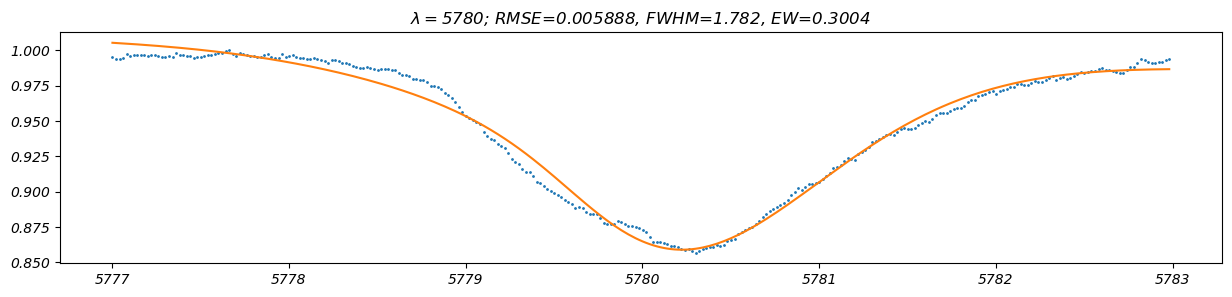

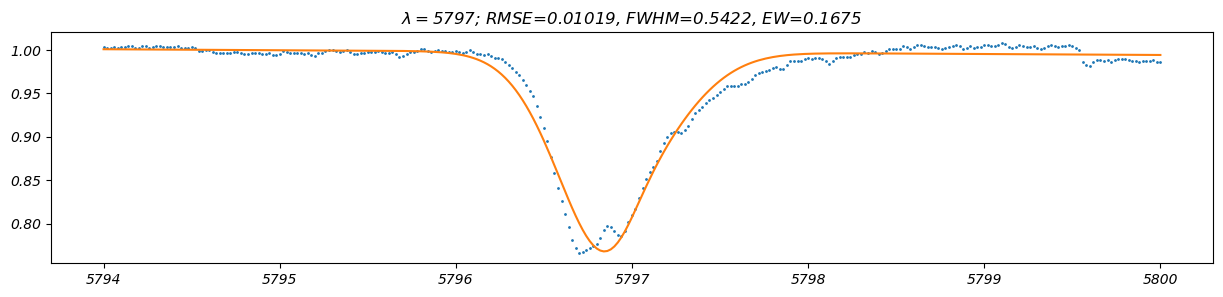

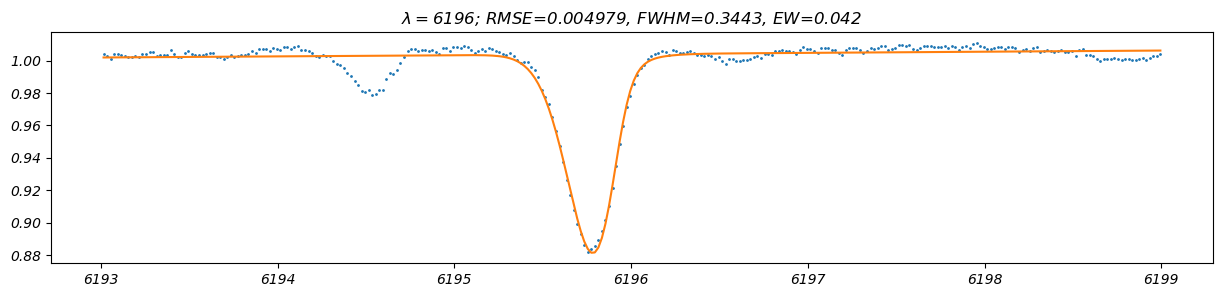

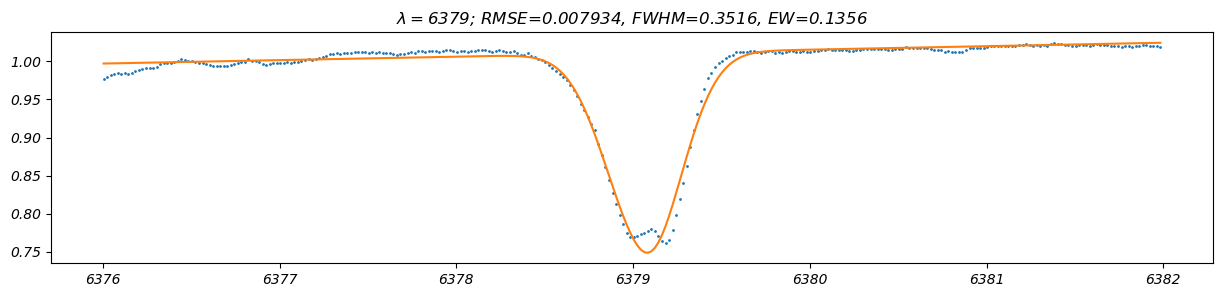

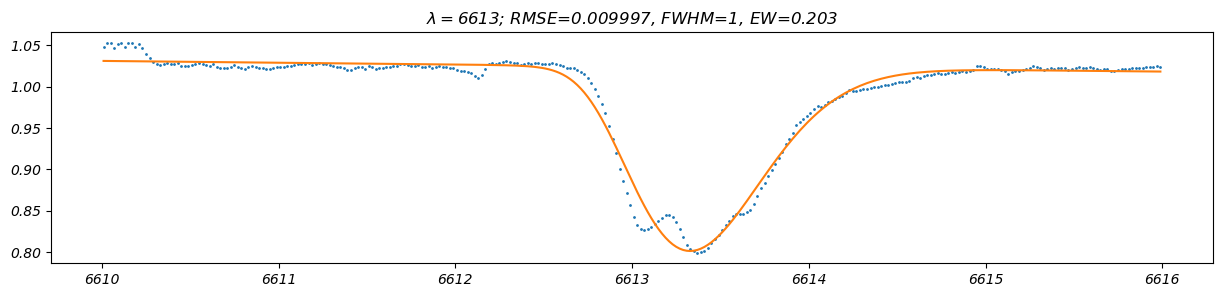

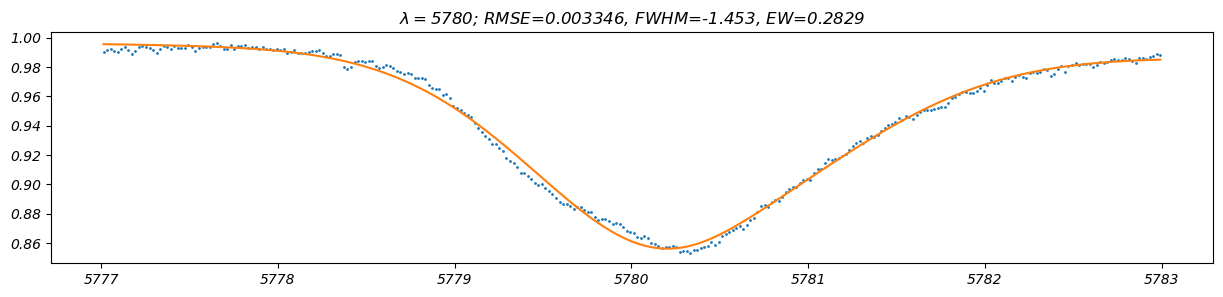

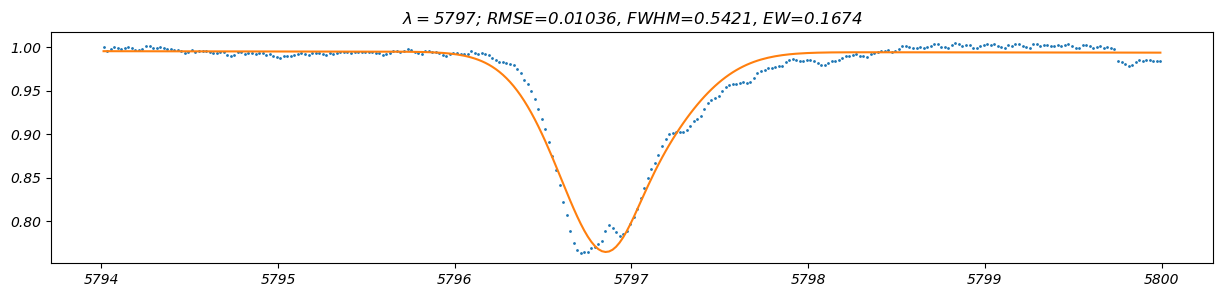

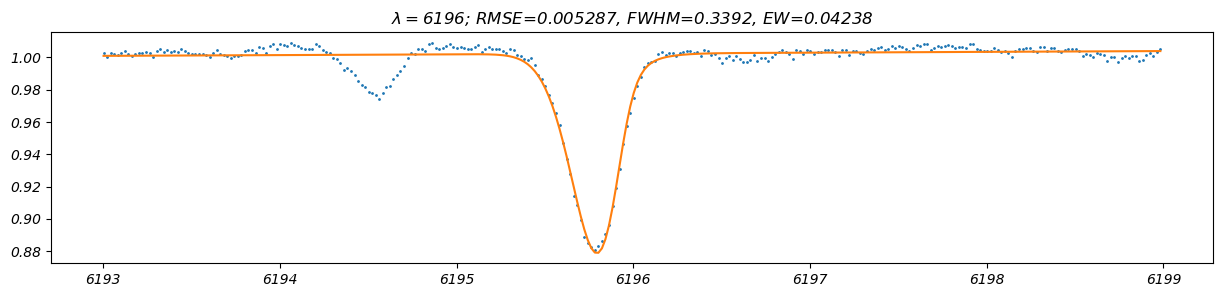

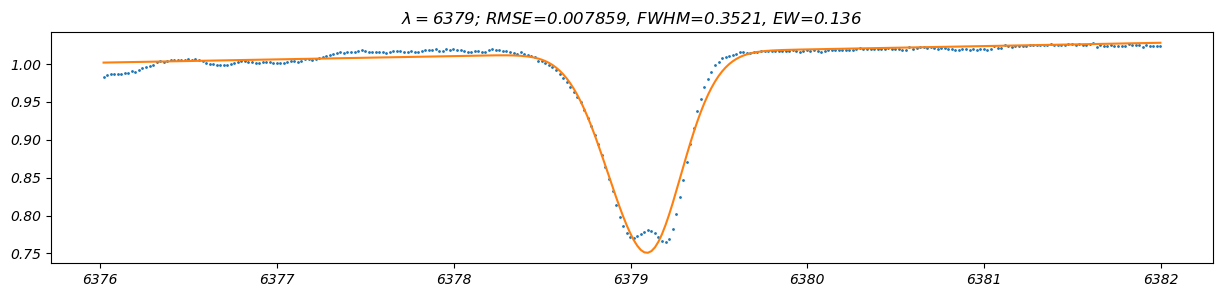

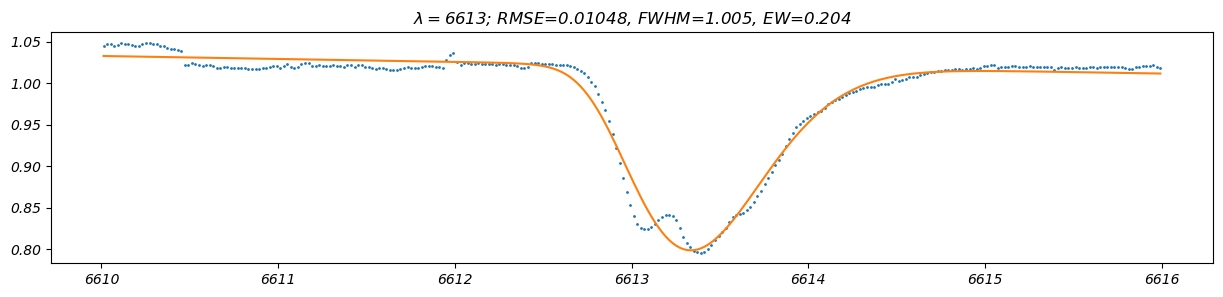

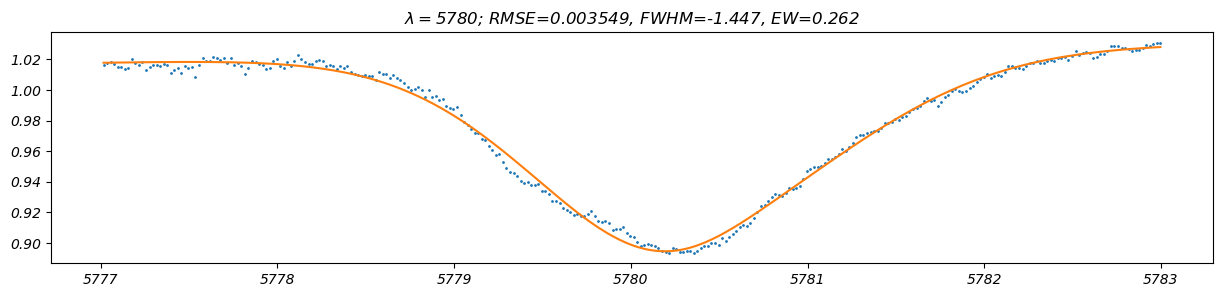

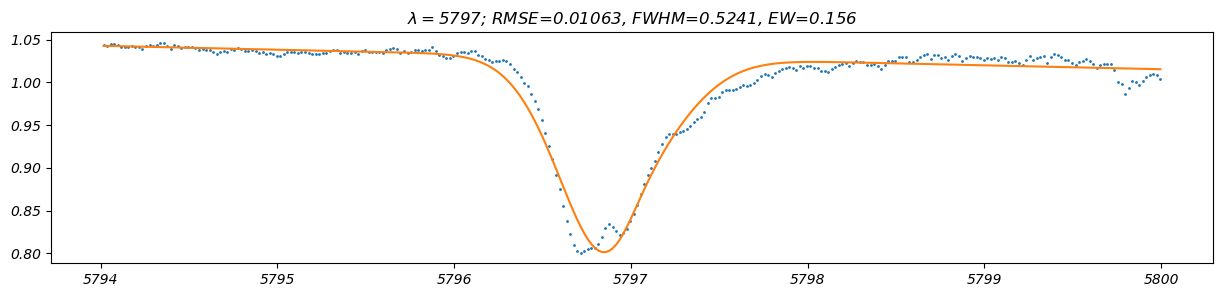

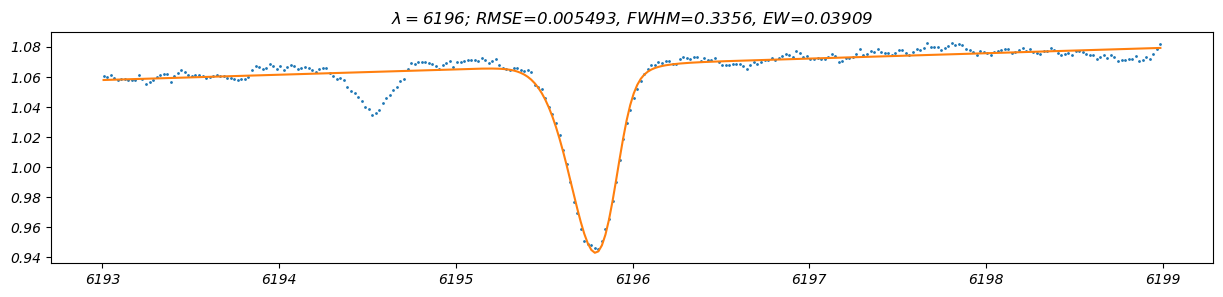

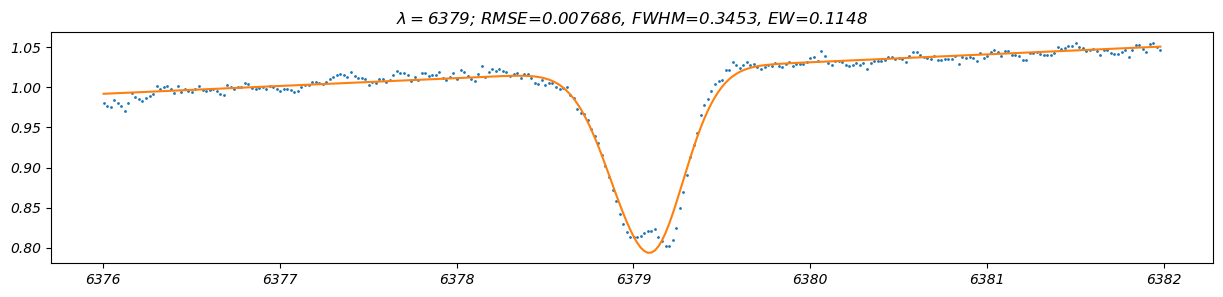

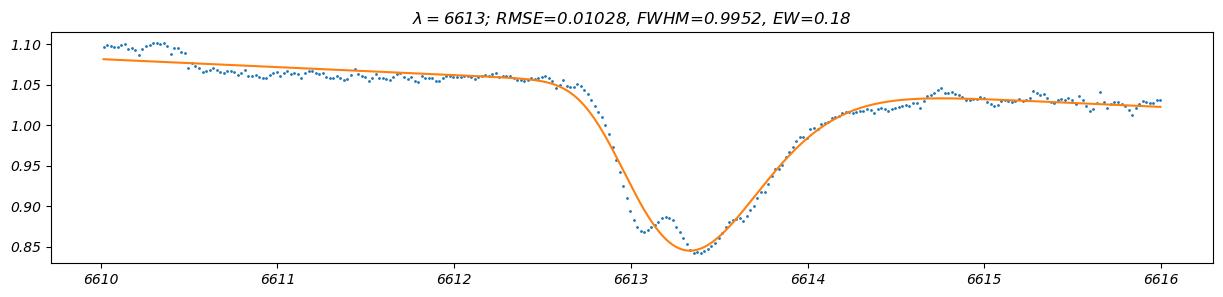

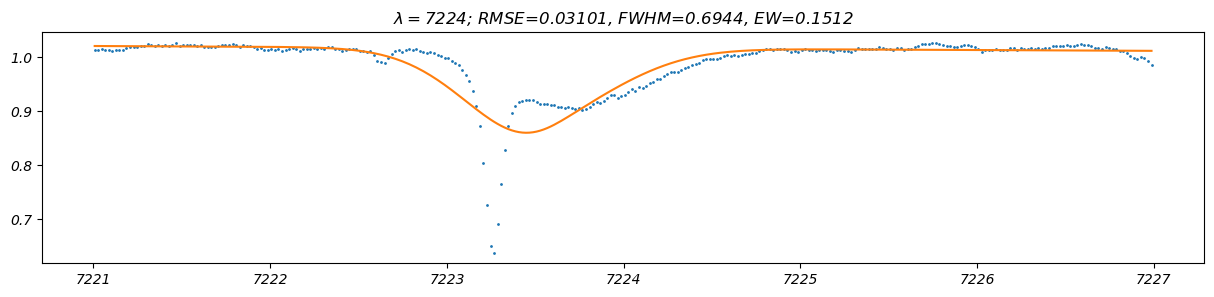

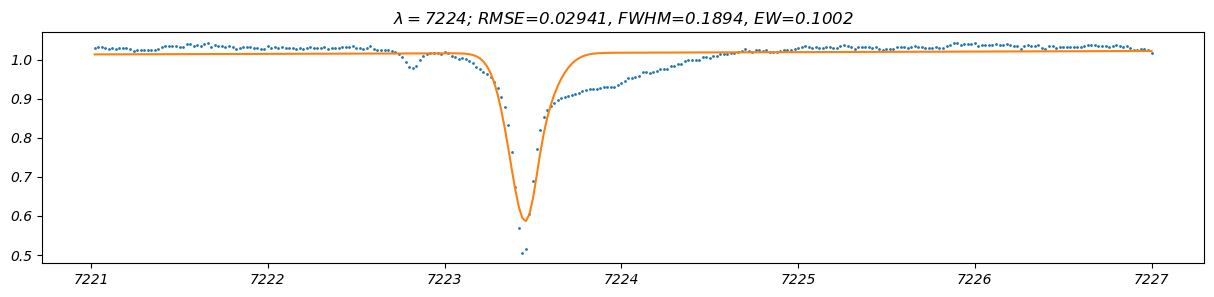

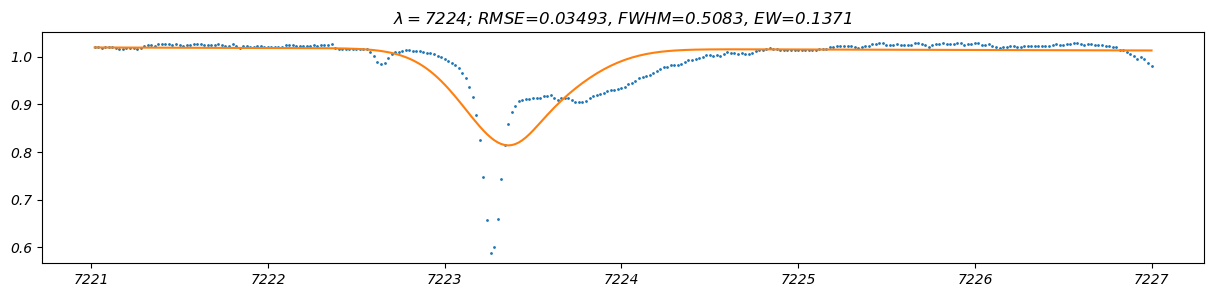

In [42]:
def load_target(target_dir: str) -> list[FitsSpectrum]:
    return [FitsSpectrum(datafile) for band_dir in list_directories(target_dir) for datafile in list_files(band_dir)]

hd185859 = load_target('data/fits/HD185859')
table_headers = ['Observation date', 'Target', 'Expected center [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'Slope', 'Start', 'RMSE', 'FWHM [Å]', 'EW [Å]']
table_data = []

for subspectrum in hd185859:
    subspectrum.remove_outliers()
    subspectrum.normalize(max_degree=10)
    subspectrum.correct_shift()

    wvl_max, wvl_min = np.max(subspectrum.wavelength), np.min(subspectrum.wavelength)
    for center in dib_centra_list:
        # The DIB does not lie in this subspectrum
        if not wvl_min < center < wvl_max:
            continue

        fig, ax = plt.subplots(1, 1, figsize=(15, 3))
        result = subspectrum.select_dib(center, (3, 3), ax=ax)

        if result is None:
            continue

        _, params, rmse, fwhm, ew, is_double = result
        table_data.append([subspectrum.obs_date, subspectrum.target, center, *params, rmse, fwhm, ew])

tabulate(table_data, table_headers, tablefmt='html')

In [ ]:
table_headers = ['Observation date', 'Target', 'Expected center [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'Slope', 'Start', 'RMSE', 'FWHM [Å]', 'EW [Å]']
table_data = []

def fit_gaussian_for_target(target: str):
    subspectra = load_target(f'data/fits/{target}')
    
    for subspectrum in subspectra:
        subspectrum.remove_outliers()
        subspectrum.normalize(max_degree=10)
        subspectrum.correct_shift()

        wvl_max, wvl_min = np.max(subspectrum.wavelength), np.min(subspectrum.wavelength)
        for center in dib_centra_list:
            # The DIB does not lie in this subspectrum
            if not wvl_min < center < wvl_max:
                continue

            result = subspectrum.select_dib(center)

            if result is None:
                continue

            _, params, rmse, fwhm, ew = result
            table_data.append([subspectrum.obs_date, subspectrum.target, center, *params, rmse, fwhm, ew])

for target in ['HD147889', 'HD170740', 'HD185859']:
    fit_gaussian_for_target(target)

np.savetxt('out/gaussian_fits_selected.txt', table_data, fmt='%s')
tabulate(table_data, table_headers, tablefmt='html')

In [ ]:
table_data = []
for target in os.listdir('data/fits'):
    fit_gaussian_for_target(target)

np.savetxt('out/gaussian_fits_all.txt', table_data, fmt='%s')